In [1]:
import time
import numpy as np
import os
from tqdm.notebook import tqdm
import pickle
from sklearn.discriminant_analysis import _cov
import scipy
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

def load_data(file):
   
    print('loading file: ' + file)
    with open(file, 'rb') as f:
        data = pickle.load(f)

    return(data)

def dump_data(data, filename):
    print('writing file: ' + filename)
    with open(filename, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def subsample_data(dat, sub_factor):
    dshape = dat['eeg'].shape
    sub_ix = list(range(0, dshape[-1], sub_factor))
    dat['eeg'] = dat['eeg'][:,:,sub_ix]
    dat['time'] = dat['time'][sub_ix]
    
    return dat
    
def get_pseudotrials(eeg_dat, tr_num):
    shape = eeg_dat.shape
    k = shape[1]
    l = int(shape[1] / k)
    
    while l < int(tr_num):
        k = k - 1
        l = int(shape[1] / k)

    eeg_dat = eeg_dat[:,np.random.permutation(shape[1]),:,:]
    eeg_dat = eeg_dat[:,:l*k,:,:]

    pst = np.reshape(eeg_dat, (shape[0], k, l, shape[2],shape[3]))
    pst = pst.mean(axis=1)

    return(pst, k)

def average_across_points(dat, window_size=10):
    dshape = dat['eeg'].shape
    
    new_length = dshape[-1] // window_size
    eeg_reshaped = dat['eeg'][:, :, :new_length * window_size].reshape(dshape[0], dshape[1], new_length, window_size)
    dat['eeg'] = eeg_reshaped.mean(axis=-1)
    dat['time'] = dat['time'][:new_length * window_size].reshape(new_length, window_size).mean(axis=-1)
    
    return dat

In [2]:
### Load Data
sub = 9
conditions_1 = ["img", "fix"]
conditions_2 = ["rand", "det"]
subsample_factor = 10
testsize = 0.2
trial_num = 12
img_nperms = 100
trial_lim = 110

decoding_data = {}

for cond in conditions_1:
    for cond2 in conditions_2:
        cond_name = "{}_{}".format(cond, cond2)
        decoding_data[cond_name] = []
        
        print(cond_name)
        dat_name = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_{:04d}_{}.pickle".format(sub, cond)
        dat = load_data(dat_name)

        ### Subsample data
        #dat = subsample_data(dat, subsample_factor)
        dat = average_across_points(dat, window_size=10)

        
        ### Button press mask
        bt_press = dat["button_press_mask"]
        dat["eeg"] = dat["eeg"][~bt_press]
        dat["ids"] = dat["ids"][~bt_press]
        dat["block_num"] = dat["block_num"][~bt_press]

        ### Select condition 
        image_labels = [1,2,3,4]
        if cond2 == "rand":
            image_labels = [im + 10 for im in image_labels]

        mask = np.isin(dat["ids"], image_labels)

        eeg_ = dat["eeg"][mask]
        ids_ = dat["ids"][mask]
        blocks = dat["block_num"][mask]
        

        ### Get vars
        n_conditions = len(image_labels)
        n_sensors = eeg_.shape[1]
        n_time = eeg_.shape[-1]

        # DA matrix 
        TG = np.full((n_conditions, n_conditions, n_time), np.nan)

        ### Randomly pick 300 trials per conditoin  
        eeg_svm = np.full((len((np.unique(ids_))), trial_lim, eeg_.shape[1], eeg_.shape[2]), np.nan)
       

        for p in tqdm(range(img_nperms)):
            for idx, x in enumerate(np.unique(ids_)):
                total_num_trials = len(ids_[ids_ == x])

                # Define the range
                range_array = np.arange(0, total_num_trials)

                # Pick x random idx without repetition
                random_numbers = np.random.choice(range_array, trial_lim, replace=False)

                # Select
                eeg_svm[idx, :, :, :] = eeg_[ids_== x][random_numbers, :, :]


            pstrials, binsize = get_pseudotrials(eeg_svm, trial_num)  
            n_pstrials = pstrials.shape[1]
            n_test = int(n_pstrials * testsize)
            #print(f'binsize: {binsize}, N of pstrials: {n_pstrials}, N sensors:{n_sensors}')

            ps_ixs = np.arange(n_pstrials)
            cvs = int(n_pstrials / n_test)

            for cv in range(cvs):
                #print('cv: {}, out of: {}'.format(cv+1, cvs))

                # we take idxs for the test/train
                test_ix = np.arange(n_test) + (cv * n_test)
                train_ix = np.delete(ps_ixs.copy(), test_ix)

                # subset idxs from the pseudotrials 
                ps_train = pstrials[:,train_ix,:,:]
                ps_test = pstrials[:,test_ix,:,:]

                # Whitening using the Epoch method // multivariate noise norm - it uses the cov b/w channels
                # https://www.sciencedirect.com/science/article/abs/pii/S1053811918301411
                # https://doi.org/10.1016/j.neuroimage.2015.12.012
                sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
                for c in range(n_conditions):
                    # compute sigma for each time point, then average across time
                    sigma_[c] = np.mean([_cov(ps_train[c, :, :, t], shrinkage='auto')
                                         for t in range(n_time)], axis=0)
                sigma = sigma_.mean(axis=0)  # average across conditions
                # the formula is sigma * -1/2 // reason for sigma_inv
                sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)

                # apply sigma to pseudo trials 
                ps_train = (ps_train.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)
                ps_test = (ps_test.swapaxes(2, 3) @ sigma_inv).swapaxes(2, 3)
                #print('Whitening done!')
                #print('-' * 20)

                #################
                # decoding: cA image vs cB (cA + 1 :) // then do it for each time point 
                for cA in range(n_conditions):
                    #print('decoding image ' + str(cA))
                    for cB in range(cA+1, n_conditions):
                        for t in range(n_time):
                            # retrieve the patterns from pseudotrials that correspond to cA and cB at time pt t
                            train_x = np.array((ps_train[cA,:,:,t], ps_train[cB,:,:,t]))
                            # concatinate them
                            train_x = np.reshape(train_x,(len(train_ix)*2, n_sensors))
                            # do the same with the test set, but here we take all time points 
                            test_x = np.array((ps_test[cA], ps_test[cB]))
                            test_x = np.reshape(test_x,(len(test_ix)*2, n_sensors, n_time))
                            # config labesls 1 for cA and 2 for cB
                            train_y = np.array([1] * len(train_ix) + [2] * len(train_ix))
                            test_y = np.array([1] * len(test_ix) + [2] * len(test_ix))

                            # instantiate a classifier 
                            classifier = LinearSVC(dual=True,
                                                    penalty = 'l2',
                                                    loss = 'hinge',
                                                    C = .5,
                                                    multi_class = 'ovr',
                                                    fit_intercept = True,
                                                    max_iter = 10000)
                            # train it
                            classifier.fit(train_x, train_y)

                            # test it on same time points 
                            pred_y = classifier.predict(test_x[:,:,t])
                            acc_score = accuracy_score(test_y,pred_y)                      
                            # we store the acc score in the da mattrix 
                            TG[cA,cB,t] = np.nansum(np.array((TG[cA,cB,t],acc_score)))


        TG = TG / (img_nperms * cvs)
        decoding_data[cond_name] = TG
        
dump_data(decoding_data, "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_{:04d}.pickle".format(sub))

img_rand
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0009_img.pickle


  0%|          | 0/100 [00:00<?, ?it/s]

img_det
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0009_img.pickle


  0%|          | 0/100 [00:00<?, ?it/s]

fix_rand
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0009_fix.pickle


  0%|          | 0/100 [00:00<?, ?it/s]

fix_det
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0009_fix.pickle


  0%|          | 0/100 [00:00<?, ?it/s]

writing file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0009.pickle


In [6]:
np.sum(bt_press)

1279

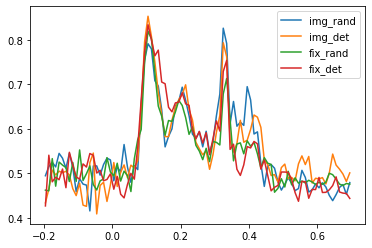

In [3]:
import matplotlib.pyplot as plt
for key in decoding_data.keys():
    vec = []
    for t in range(decoding_data[key].shape[-1]):
        vec.append(np.nanmean(decoding_data[key][:,:,t]))
    
    plt.plot(dat["time"], vec, label = key)

plt.legend()